In [1]:
from data_processing import get_data
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.layers import Input, LSTM, Dense, concatenate
from keras import Model, optimizers, losses, metrics
import matplotlib.pyplot as plt

print(tf.config.list_physical_devices('GPU'))

C:\Users\drago\anaconda3\envs\Abnormal-Trajectory-Detection\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [138]:
normal_data, abnormal_data, _, _ = get_data("york")

Normal data shape: (8200, 101)
Abnormal data shape: (1620, 101)
Real abnormal data shape: (2, 1)
Real abnormal data 2 shape: (2, 1)


C:\Users\drago\anaconda3\envs\Abnormal-Trajectory-Detection\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\drago\anaconda3\envs\Abnormal-Trajectory-Detection\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\drago\anaconda3\envs\Abnormal-Trajectory-Detection\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\drago\anaconda3\envs\Abnormal-Trajectory-Detection\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [139]:
# Transform torch tensors to keras tensors
normal_data = tf.convert_to_tensor(normal_data)
abnormal_data = tf.convert_to_tensor(abnormal_data)

In [140]:
data = tf.concat([normal_data, abnormal_data], 0)
data.shape

TensorShape([9820, 101])

In [124]:
# Create the labels, since we will be doing supervised learning. 1 represents a normal trajectory, 0 is abnormal
labels = np.concatenate([
    np.ones(normal_data.shape[0]),
    np.zeros(abnormal_data.shape[0])
], 0)

labels = np.reshape(labels, [-1, 1])
labels.shape

(9820, 1)

In [125]:
# Let's see the distribution of normal and abnormal data
neg, pos = tf.math.bincount(labels)
total = neg + pos
print('Examples:\n    Total: {}\n    Normal: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 9820
    Normal: 8200 (83.50% of total)



In [126]:
data = tf.concat([data, labels], 1)
data.shape

TensorShape([9820, 102])

In [127]:
train_data, test_data = train_test_split(data.numpy(), test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.2)

In [128]:
train_labels = train_data[:,-1].astype('int32')
train_categories = train_data[:,0].astype('int32')
train_data = train_data[:,1:-1]

val_labels = val_data[:,-1].astype('int32')
val_categories = val_data[:,0].astype('int32')
val_data = val_data[:,1:-1]

test_labels = test_data[:,-1].astype('int32')
test_categories = test_data[:,0].astype('int32')
test_data = test_data[:,1:-1]

In [129]:
print(train_labels.shape)
print(train_categories.shape)
print(train_data.shape)

(6284,)
(6284,)
(6284, 100)


array([7180, 2640], dtype=int64)

In [18]:
# The category data needs to be one-hot encoded
train_categories = np.reshape(train_categories, newshape=[-1, 1])
val_categories = np.reshape(val_categories, newshape=[-1, 1])
test_categories = np.reshape(test_categories, newshape=[-1, 1])

one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(train_categories)
one_hot_encoder.fit(val_categories)
one_hot_encoder.fit(test_categories)

train_categories = one_hot_encoder.transform(train_categories)
val_categories = one_hot_encoder.transform(val_categories)
test_categories = one_hot_encoder.transform(test_categories)

In [19]:
train_categories.shape

(6284, 2)

In [21]:
# The trajectory data however needs to be reshaped into data containing 50 timesteps for 2 features.
# The trajectory features are the x and y location 50 timesteps

features = 2
timesteps = int(train_data.shape[1] / features)

train_data = np.transpose(np.reshape(train_data, newshape=[-1, timesteps, features]), axes=[0, 2, 1])
val_data = np.transpose(np.reshape(val_data, newshape=[-1, timesteps, features]), axes=[0, 2, 1])
test_data = np.transpose(np.reshape(test_data, newshape=[-1, timesteps, features]), axes=[0, 2, 1])

train_data.shape

(6284, 2, 50)

In [22]:
train_labels.shape

(6284,)

In [23]:
bool_train_labels = train_labels != 0

pos_features = train_data[bool_train_labels]
neg_features = train_data[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

pos_categories = train_categories[bool_train_labels]
neg_categories = train_categories[~bool_train_labels]

In [24]:
ids = np.arange(len(neg_features))
choices = np.random.choice(ids, len(pos_features))

res_neg_features = neg_features[choices]
res_neg_labels = neg_labels[choices]
res_neg_categories = neg_categories[choices]

res_neg_features.shape

(5269, 2, 50)

In [25]:
print(res_neg_features.shape)
print(pos_features.shape)

(5269, 2, 50)
(5269, 2, 50)


In [26]:
resampled_features = np.concatenate([res_neg_features, pos_features], axis=0)
resampled_labels = np.concatenate([res_neg_labels, pos_labels], axis=0)
resampled_categories = np.concatenate([res_neg_categories, pos_categories], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]
resampled_categories = resampled_categories[order]

print(resampled_features.shape)
print(resampled_labels.shape)
print(resampled_categories.shape)

(10538, 2, 50)
(10538,)
(10538, 2)


In [27]:
BATCH_SIZE=128

resampled_steps_per_epoch = np.ceil(2.0*pos.numpy()/BATCH_SIZE)
resampled_steps_per_epoch

129.0

In [40]:
# Now to define the network

# Trajectory data
trajectory_input_shape = resampled_features.shape[1:]
units = 100
trajectory_input = Input(shape=trajectory_input_shape)
trajectory_output = LSTM(units)(trajectory_input)

# Category data
category_input = Input(shape=resampled_categories.shape[1:])

# Merge and add dense layer
merge_layer = concatenate([category_input, trajectory_output])
main_output = Dense(units=1,activation="sigmoid")(merge_layer)

# Define the model with two inputs
model = Model(inputs=[trajectory_input, category_input], outputs=[main_output])

In [41]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'),
      metrics.BinaryAccuracy(name='accuracy')
]

model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.BinaryCrossentropy(),
    metrics=METRICS
)

In [42]:
EPOCHS = 20

resampled_history = model.fit(
    [resampled_features, resampled_categories],
    resampled_labels,
    # These are not real epochs
    steps_per_epoch=resampled_steps_per_epoch,
    epochs=EPOCHS,
    validation_data=([val_data, val_categories], val_labels))

Epoch 1/20
129/129 [==============================] - 4s 14ms/step - loss: 0.6417 - tp: 3395.0000 - fp: 2014.0000 - tn: 3255.0000 - fn: 1874.0000 - accuracy: 0.6310 - val_loss: 0.6245 - val_tp: 739.0000 - val_fp: 48.0000 - val_tn: 227.0000 - val_fn: 558.0000 - val_accuracy: 0.6145
Epoch 2/20
129/129 [==============================] - 1s 10ms/step - loss: 0.5290 - tp: 3684.0000 - fp: 1094.0000 - tn: 4175.0000 - fn: 1585.0000 - accuracy: 0.7458 - val_loss: 0.4633 - val_tp: 987.0000 - val_fp: 67.0000 - val_tn: 208.0000 - val_fn: 310.0000 - val_accuracy: 0.7602
Epoch 3/20
129/129 [==============================] - 1s 10ms/step - loss: 0.4583 - tp: 4095.0000 - fp: 994.0000 - tn: 4275.0000 - fn: 1174.0000 - accuracy: 0.7943 - val_loss: 0.4560 - val_tp: 981.0000 - val_fp: 50.0000 - val_tn: 225.0000 - val_fn: 316.0000 - val_accuracy: 0.7672
Epoch 4/20
129/129 [==============================] - 1s 10ms/step - loss: 0.3821 - tp: 4402.0000 - fp: 882.0000 - tn: 4387.0000 - fn: 867.0000 - accuracy:

In [43]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

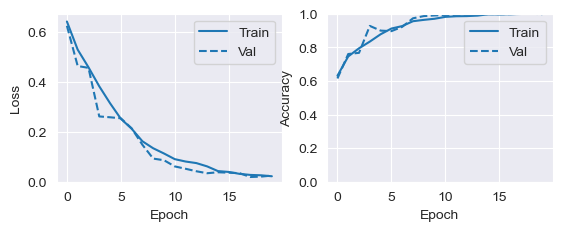

In [44]:
plot_metrics(resampled_history)

In [45]:
resampled_results = model.evaluate([test_data, test_categories], test_labels, batch_size=BATCH_SIZE, verbose=0)

In [46]:
for name, value in zip(model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

loss :  0.029067782685160637
tp :  1626.0
fp :  0.0
tn :  330.0
fn :  8.0
accuracy :  0.9959266781806946



In [47]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [48]:
test_predictions = model.predict([test_data, test_categories], batch_size=BATCH_SIZE)

16/16 [==============================] - 1s 4ms/step


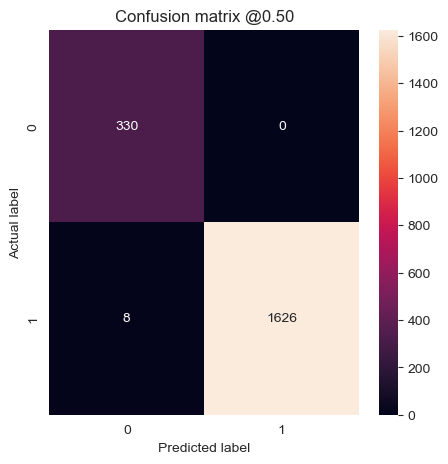

In [49]:
plot_cm(test_labels, test_predictions)

In [153]:
pred = [0 if p < 0.5 else 1 for p in test_predictions]
wrong_predictions = [i for i in range(len(pred)) if pred[i] != test_labels[i]]
len(wrong_predictions)

524

In [109]:
wrong_trajectories = test_data[wrong_predictions]
wrong_categories = test_categories[wrong_predictions]

wrong_trajectories[0]

array([[0.13573458, 0.14207459, 0.14828964, 0.14665987, 0.1437246 ,
        0.13897903, 0.14552626, 0.13405398, 0.14148697, 0.1440405 ,
        0.14410134, 0.15138724, 0.13952504, 0.13237494, 0.14663824,
        0.14308685, 0.14099507, 0.13435974, 0.14382322, 0.14034986,
        0.13934251, 0.1357711 , 0.13624516, 0.15069192, 0.15094444,
        0.1267802 , 0.12351834, 0.12758176, 0.14054283, 0.14656786,
        0.13722284, 0.14762085, 0.14624768, 0.1301388 , 0.13413216,
        0.1432534 , 0.14769197, 0.14149904, 0.14061017, 0.1389464 ,
        0.13140432, 0.13614247, 0.14465731, 0.14709063, 0.13170013,
        0.14164731, 0.12875217, 0.13109309, 0.12777151, 0.13450885],
       [0.21760976, 0.23519383, 0.23783808, 0.20498604, 0.21499832,
        0.19642056, 0.18767565, 0.20504518, 0.18591741, 0.21719452,
        0.20056413, 0.2064641 , 0.20271171, 0.18405671, 0.21677921,
        0.19012292, 0.19723934, 0.19535396, 0.15980028, 0.18927858,
        0.17243132, 0.15506207, 0.19109133, 0.1

In [150]:
for i, d in enumerate(data):
    if (d[1:].numpy() == wrong_trajectories[0]).all():
        print("Wow " + str(i))

Wow 7948


In [151]:
data[7948]

<tf.Tensor: shape=(101,), dtype=float64, numpy=
array([1.        , 0.57512266, 0.32783793, 0.57124461, 0.32921482,
       0.56585955, 0.32542694, 0.5743269 , 0.31742962, 0.57414229,
       0.31223719, 0.56509813, 0.31802785, 0.56123188, 0.30482579,
       0.57409794, 0.29324532, 0.57722745, 0.30480362, 0.56696646,
       0.30654851, 0.55663258, 0.29112366, 0.58778421, 0.33106443,
       0.56957885, 0.33168252, 0.57198422, 0.29066651, 0.57272268,
       0.29501148, 0.55819561, 0.32449279, 0.56524627, 0.29016979,
       0.55145375, 0.2823658 , 0.56000578, 0.29209655, 0.56464762,
       0.29125799, 0.55050857, 0.27694533, 0.55355608, 0.29738793,
       0.55521675, 0.31088314, 0.56210185, 0.29104527, 0.55531101,
       0.26256281, 0.55963621, 0.30513226, 0.56581733, 0.27767106,
       0.55410902, 0.29948972, 0.56411502, 0.30364282, 0.5509573 ,
       0.26167581, 0.54884606, 0.29970509, 0.54311142, 0.3045297 ,
       0.540386  , 0.29692466, 0.54149826, 0.28595715, 0.5466414 ,
       0.29236

In [113]:
from sklearn.preprocessing import MinMaxScaler

# Create normal trajectories dataset
normal_data_file = f"./data/york/york_gt_data.csv"
test = np.genfromtxt(normal_data_file, delimiter=',')
# Remove the first column, which is the object_id
test = test[:, 1:]
print(f"Normal data shape: {test.shape}")


scaler = MinMaxScaler()
test_scaled = scaler.fit_transform(test)
# normal_data_scaled = torch.from_numpy(normal_data_scaled).to(dtype=torch.float32)

Normal data shape: (8200, 101)


In [100]:
test[0]

array([  0.       , 422.3856851, 279.9533701, 437.7946189, 286.5369634,
       428.8821602, 279.8443788, 430.3509238, 281.1354365, 438.9600383,
       271.9244025, 438.6606241, 282.9906192, 429.2029479, 275.5133624,
       431.5110439, 279.2267461, 434.2209977, 272.8534763, 443.5145085,
       287.472199 , 435.2776958, 279.1100211, 440.7656907, 282.7065242,
       441.275288 , 285.873619 , 429.6292339, 286.5030264, 442.9017758,
       279.5966005, 435.5474545, 284.2526994, 443.0244957, 297.083324 ,
       438.6143126, 280.3797328, 444.3502653, 281.6247503, 441.5473162,
       283.4354961, 435.6586595, 292.533212 , 449.0646388, 280.0790454,
       446.7888787, 278.9957703, 449.9652919, 281.5033085, 441.9354983,
       286.5063867, 447.4126265, 292.0227297, 444.1231251, 286.2088435,
       451.1068847, 290.073412 , 433.2762366, 284.0683627, 449.5042521,
       285.6580764, 449.9015508, 294.1502728, 446.7528227, 290.0289896,
       454.5421918, 293.2531025, 442.4069947, 294.4217708, 456.4

In [103]:
test_scaled[0]

array([0.        , 0.57779306, 0.35984167, 0.59389294, 0.38265392,
       0.58369339, 0.35242881, 0.5823525 , 0.35853256, 0.60311324,
       0.33943777, 0.59638793, 0.35834188, 0.58426505, 0.33378988,
       0.59068016, 0.35173217, 0.59494257, 0.32587335, 0.60718444,
       0.39420781, 0.59460615, 0.35170646, 0.605605  , 0.36148842,
       0.60622578, 0.38150358, 0.59273148, 0.368737  , 0.6150764 ,
       0.34521018, 0.60112142, 0.37139369, 0.61105584, 0.41431425,
       0.60750058, 0.35778199, 0.62107003, 0.34737273, 0.61330599,
       0.37034503, 0.60128774, 0.39858174, 0.61993837, 0.35102954,
       0.62135153, 0.35756811, 0.62706501, 0.36566193, 0.61759829,
       0.38147896, 0.62762181, 0.40383758, 0.62099892, 0.3743848 ,
       0.62672279, 0.39168454, 0.6046473 , 0.37954265, 0.62483429,
       0.38322789, 0.62896072, 0.41935722, 0.62111702, 0.39901686,
       0.62467345, 0.42215418, 0.60327481, 0.42411139, 0.62710447,
       0.38767884, 0.61451542, 0.40576334, 0.6273745 , 0.39611

In [118]:
scaler.inverse_transform(test_scaled)[0]

array([  0.       , 422.3856851, 279.9533701, 437.7946189, 286.5369634,
       428.8821602, 279.8443788, 430.3509238, 281.1354365, 438.9600383,
       271.9244025, 438.6606241, 282.9906192, 429.2029479, 275.5133624,
       431.5110439, 279.2267461, 434.2209977, 272.8534763, 443.5145085,
       287.472199 , 435.2776958, 279.1100211, 440.7656907, 282.7065242,
       441.275288 , 285.873619 , 429.6292339, 286.5030264, 442.9017758,
       279.5966005, 435.5474545, 284.2526994, 443.0244957, 297.083324 ,
       438.6143126, 280.3797328, 444.3502653, 281.6247503, 441.5473162,
       283.4354961, 435.6586595, 292.533212 , 449.0646388, 280.0790454,
       446.7888787, 278.9957703, 449.9652919, 281.5033085, 441.9354983,
       286.5063867, 447.4126265, 292.0227297, 444.1231251, 286.2088435,
       451.1068847, 290.073412 , 433.2762366, 284.0683627, 449.5042521,
       285.6580764, 449.9015508, 294.1502728, 446.7528227, 290.0289896,
       454.5421918, 293.2531025, 442.4069947, 294.4217708, 456.4

In [114]:
wrong_data = scaler.inverse_transform(wrong_data)
cat = np.array(cat).reshape((8,))
wrong_data[:,0] = cat
wrong_data

array([[  2.        , 420.4472731 , 338.50214388, 417.52610795,
        339.96821334, 421.95418708, 338.64709155, 415.10400728,
        339.38773508, 420.30641938, 335.87350342, 410.2338552 ,
        345.35192158, 418.59521989, 340.18415042, 418.62573121,
        335.90837595, 412.9626037 , 333.91258836, 409.88518743,
        334.3170255 , 403.83493675, 334.18145633, 405.06009797,
        337.22823865, 405.27916776, 333.98124443, 410.58998575,
        336.08023426, 407.04599596, 334.4708183 , 398.27978742,
        330.2350887 , 393.48401906, 331.12582561, 396.13155647,
        328.29710047, 384.00321554, 326.34707059, 383.83846449,
        323.30228729, 377.74795682, 324.91497952, 375.21946118,
        324.85338166, 374.37311935, 320.48132823, 370.04842983,
        318.33919165, 361.46441176, 318.00417726, 239.32054349,
        272.16870563, 238.82511966, 270.88266669, 231.85848178,
        269.71734564, 224.33018834, 260.60166591, 225.38220818,
        265.12967297, 212.25601463, 270.

Plotting trajectory 1/8
Plotting trajectory 2/8
Plotting trajectory 3/8
Plotting trajectory 4/8
Plotting trajectory 5/8
Plotting trajectory 6/8
Plotting trajectory 7/8
Plotting trajectory 8/8


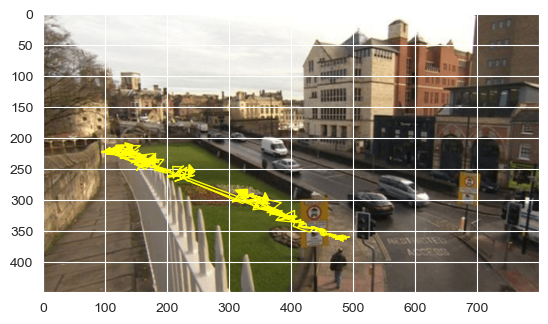

Done


In [94]:
from trajectory_viewer_york import show_trajectories
image = 'data/images/' + 'york' + '.png'
show_trajectories(image, wrong_data, ['green', 'blue', 'yellow'])

In [106]:
normal_data[0]

<tf.Tensor: shape=(101,), dtype=float64, numpy=
array([0.        , 0.57779306, 0.35984167, 0.59389294, 0.38265392,
       0.58369339, 0.35242881, 0.5823525 , 0.35853256, 0.60311324,
       0.33943777, 0.59638793, 0.35834188, 0.58426505, 0.33378988,
       0.59068016, 0.35173217, 0.59494257, 0.32587335, 0.60718444,
       0.39420781, 0.59460615, 0.35170646, 0.605605  , 0.36148842,
       0.60622578, 0.38150358, 0.59273148, 0.368737  , 0.6150764 ,
       0.34521018, 0.60112142, 0.37139369, 0.61105584, 0.41431425,
       0.60750058, 0.35778199, 0.62107003, 0.34737273, 0.61330599,
       0.37034503, 0.60128774, 0.39858174, 0.61993837, 0.35102954,
       0.62135153, 0.35756811, 0.62706501, 0.36566193, 0.61759829,
       0.38147896, 0.62762181, 0.40383758, 0.62099892, 0.3743848 ,
       0.62672279, 0.39168454, 0.6046473 , 0.37954265, 0.62483429,
       0.38322789, 0.62896072, 0.41935722, 0.62111702, 0.39901686,
       0.62467345, 0.42215418, 0.60327481, 0.42411139, 0.62710447,
       0.38767

In [107]:
scaler.inverse_transform(normal_data)[0]

array([  0.       , 422.3856851, 279.9533701, 437.7946189, 286.5369634,
       428.8821602, 279.8443788, 430.3509238, 281.1354365, 438.9600383,
       271.9244025, 438.6606241, 282.9906192, 429.2029479, 275.5133624,
       431.5110439, 279.2267461, 434.2209977, 272.8534763, 443.5145085,
       287.472199 , 435.2776958, 279.1100211, 440.7656907, 282.7065242,
       441.275288 , 285.873619 , 429.6292339, 286.5030264, 442.9017758,
       279.5966005, 435.5474545, 284.2526994, 443.0244957, 297.083324 ,
       438.6143126, 280.3797328, 444.3502653, 281.6247503, 441.5473162,
       283.4354961, 435.6586595, 292.533212 , 449.0646388, 280.0790454,
       446.7888787, 278.9957703, 449.9652919, 281.5033085, 441.9354983,
       286.5063867, 447.4126265, 292.0227297, 444.1231251, 286.2088435,
       451.1068847, 290.073412 , 433.2762366, 284.0683627, 449.5042521,
       285.6580764, 449.9015508, 294.1502728, 446.7528227, 290.0289896,
       454.5421918, 293.2531025, 442.4069947, 294.4217708, 456.4